In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import matplotlib.image as mpimg
from scipy.integrate import cumulative_trapezoid, trapezoid
import math
import time
import random
import os
import pickle as pkl
import geopandas as gpd
from pyproj import *
from shapely.geometry import *
from cratersfd import *
%matplotlib inline

plt.rcParams['font.family'] = 'Helvetica'

In [2]:
ks10_data = pd.read_excel('../data/Sat_satel-summary.xlsx', sheet_name=None)
dione_data = pd.read_csv('../data/Dione_global_crater_database.csv')

terrains = dione_data['Geol. Unit'].value_counts().index.to_list()

with open('../data/terrain_area.txt', 'rb') as f:
    raw_text = f.read()

area_strs = str(raw_text).split('\\n\\n')[1].split('\\n')[:-1]
dione_area_dict = {
    area_str.split(': ')[0] : float(area_str.split(': ')[1]) 
    for area_str in area_strs
}
dione_d_dict = {
    terrain : np.array(
        dione_data[dione_data['Geol. Unit'] == terrain]['Diameter']
    )
    for terrain in terrains
}

lunar_crs = '+proj=longlat +a=1738100 +b=1736000 +no_defs'

crater_df = pd.read_csv('../data/lunar_crater_database_robbins_2018.csv')
farside_area = 3.793e7

lon = crater_df['LON_CIRC_IMG']
farside_df = crater_df[(lon > 90) & (lon <= 270)]

a = np.array(farside_df['DIAM_ELLI_MAJOR_IMG'])
b = np.array(farside_df['DIAM_ELLI_MINOR_IMG'])
c_d = np.array(farside_df['DIAM_CIRC_IMG'])
c_ds = c_d[c_d >= 2]
d = np.sqrt(a * b)
e = np.array(farside_df['DIAM_ELLI_ECCEN_IMG'])
farside_ds = d[d >= 2]

/Users/sam/Library/Python/3.12/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/sam/Library/Python/3.12/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/sam/Library/Python/3.12/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/sam/Library/Python/3.12/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/sam/Library/Python/3.12/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/sam/Library/Python/3.12/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and wi

In [3]:
keys = ks10_data.keys()
d_dict = {key : np.array(ks10_data[key]['D (km)']) for key in keys}
area_dict = {key : ks10_data[key]['Area (km^2)'][0] for key in keys}

Calculation time: 0.00033 seconds
Calculation time: 0.00067 seconds
Calculation time: 0.00027 seconds
Calculation time: 0.00056 seconds
Calculation time: 0.00021 seconds
Calculation time: 0.00015 seconds
Calculation time: 0.00018 seconds
Calculation time: 0.00019 seconds


/Users/sam/Data/chronology/cratersfd/src/cratersfd/random_variable_module.py:187: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([


Synthetic calculation time: 2.17118 seconds
Calculation time: 0.00052 seconds
Synthetic calculation time: 2.1958 seconds
Calculation time: 0.00056 seconds
Synthetic calculation time: 2.17538 seconds
Calculation time: 0.00046 seconds
Synthetic calculation time: 2.19619 seconds
Calculation time: 0.00022 seconds
Synthetic calculation time: 2.21069 seconds
Calculation time: 0.00022 seconds
Synthetic calculation time: 2.25786 seconds
Calculation time: 0.00011 seconds
Synthetic calculation time: 2.21647 seconds
Calculation time: 0.00015 seconds
Synthetic calculation time: 2.25684 seconds
Calculation time: 0.00015 seconds
Synthetic calculation time: 2.2916 seconds
Calculation time: 0.01541 seconds


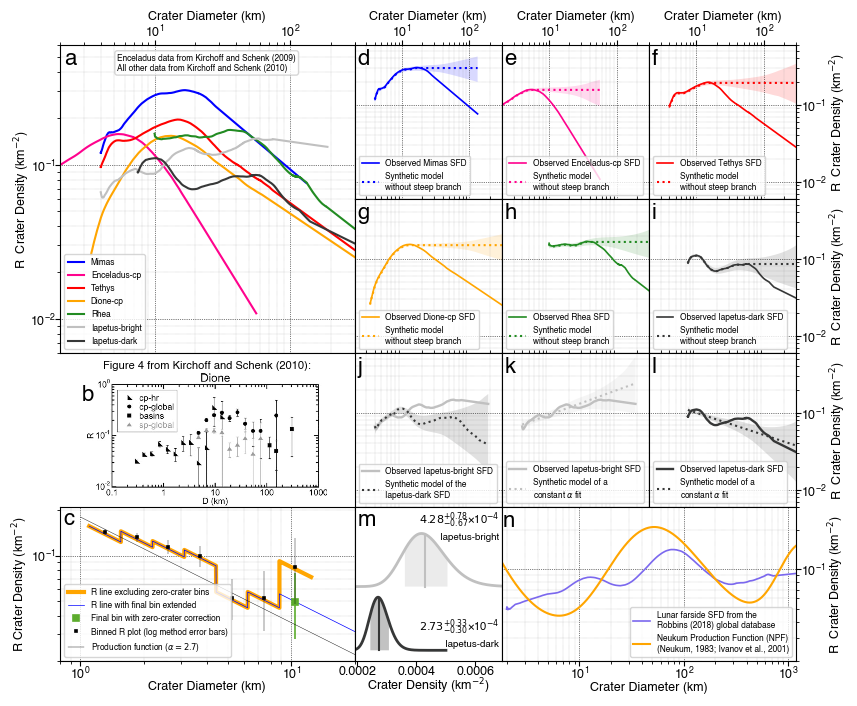

In [7]:
n_steps = 1000
fontsize = 9
ylim = [6E-3, 6E-1]
color_dict = {
    'Mimas' : 'blue', 
    'Enceladus-cp' : 'xkcd:hot pink', 
    'Tethys' : 'red', 
    'Dione-cp' : 'orange', 
    'Rhea' : 'forestgreen',
    'Iapetus-bright' : 'silver', 
    'Iapetus-dark' : 'xkcd:dark gray'
}

fig = plt.figure(figsize=(9.5, 8))

gs = gridspec.GridSpec(4, 5, figure=fig)

ax = plt.subplot(gs[2, :2])
img = mpimg.imread('../data/KirchoffAndSchenk2010Fig4.jpg')
plt.imshow(img, interpolation='none')
plt.ylim([img.shape[0], -400])
plt.text(
    0.5, 0.95, 'Figure 4 from Kirchoff and Schenk (2010):',
    transform=ax.transAxes, fontsize=8, 
    ha='center', va='top'
)
plt.axis("off")
ltr = 'b'
plt.text(
    100, 300, ltr, ha='left', va='top', size=16
)

ax = plt.subplot(gs[:2, :2])
plot_keys = [
    'Mimas', 'Enceladus-cp', 'Tethys', 'Dione-cp', 'Rhea',
    'Iapetus-bright', 'Iapetus-dark'
]
for key in plot_keys:
    ds = ks10_data[key]['D (km)']
    area = ks10_data[key]['Area (km^2)'][0]
    X, mean_Y = plot_sash_R(
        ds, area, 
        bin_width_exponent=per_decade(18), 
        d_max=2 * np.max(ds), 
        growth_rate=1.25, color=color_dict[key], 
        lw=1.5, fontsize=fontsize
    )
lines = plt.gca().get_lines()
legend = plt.legend(lines, plot_keys, fontsize=6)
plt.xlim([2, 300])
plt.ylim(ylim)
frame = legend.get_frame()
plt.text(
    5.3, 0.53, 
    (
        'Enceladus data from Kirchoff and Schenk (2009)'
        '\nAll other data from Kirchoff and Schenk (2010)'
    ),
    ha='left', va='top', fontsize=6, bbox={
        'boxstyle' : 'round',
        'facecolor' : frame.get_facecolor(),
        'edgecolor' : frame.get_edgecolor(),
        'linewidth' : frame.get_linewidth(),
        'alpha' : frame.get_alpha(),
    }
)
ltr = 'a'
plt.text(
    2.15, 0.57, ltr, ha='left', va='top', size=16
)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 3
ax.yaxis.labelpad = -2
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
ax.tick_params(axis='both', which='major', pad=0)

ax = plt.subplot(gs[3, :2])

file = '../data/zero_crater_bin_example_synthetic.csv'
zero_ds = np.loadtxt(file, delimiter=',')
synth_area = 15000
synth_pf = loglog_linear_pf(N1=1000 / synth_area, slope=-2.7)

counts, bins, _, _ = bin_craters(
    zero_ds, reference_point=1.1, bin_width_exponent=0.5
)
alpha_rv = pareto_pdf(zero_ds, dmin=bins[-2])
alpha_rv.mean(), counts[-1], tp_eq(
    np.sqrt(bins[-2] * bins[-1]), dmin=1, dmax=1E5, 
    alpha=alpha_rv.mean()
)
bin_center = np.sqrt(bins[-2] * bins[-1])
X_short, R_short = dif_line(
    np.array([2.7] * counts.size), 
    counts, synth_area, bins, return_X=True
)
R_short *= X_short**3
last_bin_d = np.sqrt(bins[-2] * bins[-1])
bins[-1] = 1E5
X_long, R_long = dif_line(
    np.array([2.7] * counts.size), 
    counts, synth_area, bins, return_X=True
)
R_long *= X_long**3

plt.plot(X_short, R_short, 'orange', lw=3)
plt.plot(X_long, R_long, 'blue', lw=0.5)

corrected_R = np.interp(last_bin_d, X_long, R_long)
lambda_rv = lambda_pdf(counts[-1])
corrected_R_rv = corrected_R * lambda_rv / lambda_rv.mode()
plot_pdf_list(
    [last_bin_d], [corrected_R_rv], color='xkcd:grass', 
    ms=4, elinewidth=1.2
)

plot_R(
    zero_ds, synth_area, reference_point=1.1, 
    bin_width_exponent=0.5, do_correction=False, 
    pf=synth_pf, fontsize=fontsize, color='black',
    ms=2, elinewidth=0.3
)
pf = differential2R_pf(
        cumulative2differential_pf(
            loglog2linear_pf(
                synth_pf
            )
        )
    )
Xpf = np.logspace(0, 3, 10000)
plt.plot(Xpf, pf(Xpf), 'black', lw=0.3)
plt.xlim([0.8, 20])
plt.ylim([2E-2, 0.21])

lines = plt.gca().get_lines()
line_labels = [
    'R line excluding zero-crater bins',
    'R line with final bin extended',
    'Final bin with zero-crater correction',
    'Binned R plot (log method error bars)',
    rf'Production function ($\alpha=2.7$)'
]
plt.legend(lines, line_labels, fontsize=6)
ltr = 'c'
plt.text(
    0.83, 0.203, ltr, ha='left', va='top', size=16
)
ax = plt.gca()
ax.xaxis.labelpad = -2
ax.yaxis.labelpad = 1
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
ax.tick_params(axis='both', which='major', pad=0)

plot_keys = [
    'Mimas', 'Enceladus-cp', 'Tethys', 'Dione-cp', 'Rhea',
    'Iapetus-dark'
]
grids = [
    gs[0, 2], gs[0, 3], gs[0, 4], gs[1, 2], gs[1, 3], gs[1, 4]
]

for key, grid, i in zip(
    plot_keys, grids, range(len(grids))
):
    ax = plt.subplot(grid)
    ds = ks10_data[key]['D (km)']
    area = ks10_data[key]['Area (km^2)'][0]
    X, mean_Y = plot_sash_R(
        ds, area, 
        bin_width_exponent=per_decade(18), 
        d_max=2 * np.max(ds), 
        growth_rate=1.25, color=color_dict[key],
        fontsize=fontsize
    )

    if key == 'Iapetus-dark':
        r_pf = fit_pf(X, mean_Y)
        at = X[X > 20][np.argmax(r_pf(X[X > 20]))]
    else:
        at = None
    saturated_pf = get_saturated_pf(
        X, mean_Y, plot_type='R', at=at
    )
    file_stem = 'saved/steep_branch_synth.'
    base = file_stem + key + '.' + str(n_steps)
    X_saved = os.path.exists(base + '.X.csv')
    Ys_saved = os.path.exists(base + '.Ys.csv')
    load_saved = X_saved and Ys_saved
    time0()
    if load_saved:
        X = np.loadtxt(base + '.X.csv', delimiter=',')
        Ys = np.loadtxt(base + '.Ys.csv', delimiter=',')
        X, Ys = plot_sash_synth(
            ds, area, plot_type='R',
            differential_pf=R2differential_pf(saturated_pf), 
            n_steps=n_steps, bin_width_exponent=per_decade(18), 
            d_max=2 * np.max(ds), growth_rate=1.3, 
            color=color_dict[key], fontsize=fontsize,
            X=X, synth_mean_Ys=Ys
        )
    else:
        X, Ys = plot_sash_synth(
            ds, area, plot_type='R',
            differential_pf=R2differential_pf(saturated_pf), 
            n_steps=n_steps, bin_width_exponent=per_decade(18), 
            d_max=2 * np.max(ds), growth_rate=1.3, 
            color=color_dict[key], fontsize=fontsize
        )
        np.savetxt(base + '.X.csv', X, delimiter=',')
        np.savetxt(base + '.Ys.csv', Ys, delimiter=',')
    runtime('Synthetic calculation time')

    lines = plt.gca().get_lines()
    plt.legend(
        lines, [
            'Observed ' + key + ' SFD', 
            'Synthetic model\nwithout steep branch'
        ], fontsize=6, loc='lower left'
    )
    plt.xlim([2, 300])
    plt.ylim(ylim)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    if i >= 3:
        plt.xticks([])
        plt.xlabel('')

    ltr = chr(ord('d') + i)
    plt.text(
        2.2, 0.53, ltr, ha='left', va='top', size=16
    )
    ax.xaxis.labelpad = 3
    ax.yaxis.labelpad = 1
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    ax.tick_params(axis='both', which='major', pad=0)

ax = plt.subplot(gs[2, 2])
key = 'Iapetus-bright'
bright_ds = ks10_data[key]['D (km)']
bright_area = ks10_data[key]['Area (km^2)'][0]
D_bright, R_bright = plot_sash_R(
    bright_ds, bright_area, 
    bin_width_exponent=per_decade(18), 
    d_max=2 * np.max(bright_ds), 
    growth_rate=1.25, color=color_dict[key], lw=1.7
)
key = 'Iapetus-dark'
dark_ds = ks10_data[key]['D (km)']
dark_area = ks10_data[key]['Area (km^2)'][0]
D_dark, R_dark = calc_sash_R(
    dark_ds, dark_area, 
    bin_width_exponent=per_decade(18), 
    d_max=2 * np.max(dark_ds), 
    growth_rate=1.25
)
X = np.linspace(7, 8, 10000)
Y_bright = np.interp(X, D_bright, R_bright)
Y_dark = np.interp(X, D_dark, R_dark)
crossover_d = X[np.argmin(np.abs(Y_bright - Y_dark))]
bright_R_pf = fit_pf(D_bright, R_bright)
dark_R_pf = fit_pf(D_dark, R_dark)
def synth_R_pf(d, crossover_d=crossover_d):
    return np.piecewise(
        d, [d < crossover_d, d >= crossover_d],
        [bright_R_pf, dark_R_pf]
    )
time0()
base = 'saved/iapetus_synth.' + str(n_steps)
X_saved = os.path.exists(base + '.X.csv')
Ys_saved = os.path.exists(base + '.Ys.csv')
load_saved = X_saved and Ys_saved
time0()
if load_saved:
    X = np.loadtxt(base + '.X.csv', delimiter=',')
    Ys = np.loadtxt(base + '.Ys.csv', delimiter=',')
    X, Ys = plot_sash_synth(
        bright_ds, bright_area, plot_type='R',
        differential_pf=R2differential_pf(synth_R_pf), 
        n_steps=n_steps, bin_width_exponent=per_decade(18), 
        d_max=2 * np.max(bright_ds), growth_rate=1.3, 
        color=color_dict['Iapetus-dark'], fontsize=fontsize,
        X=X, synth_mean_Ys=Ys
    )
else:
    X, Ys = plot_sash_synth(
        bright_ds, bright_area, plot_type='R',
        differential_pf=R2differential_pf(synth_R_pf), 
        n_steps=n_steps, bin_width_exponent=per_decade(18), 
        d_max=2 * np.max(bright_ds), growth_rate=1.3, 
        color=color_dict['Iapetus-dark'], fontsize=fontsize
    )
    np.savetxt(base + '.X.csv', X, delimiter=',')
    np.savetxt(base + '.Ys.csv', Ys, delimiter=',')
runtime('Synthetic calculation time')
i += 1
plt.xlim([2, 300])
plt.ylim(ylim)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
if i >= 3:
    plt.xticks([])
    plt.xlabel('')

ltr = chr(ord('d') + i)
plt.text(
    2.2, 0.53, ltr, ha='left', va='top', size=16
)
ax.xaxis.labelpad = 3
ax.yaxis.labelpad = 1
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
ax.tick_params(axis='both', which='major', pad=0)
lines = plt.gca().get_lines()
plt.legend(
    lines, [
        'Observed Iapetus-bright SFD', 
        'Synthetic model of the\nIapetus-dark SFD'
    ], fontsize=6, loc='lower left'
)

ax = plt.subplot(gs[2, 3])
key = 'Iapetus-bright'
bright_ds = ks10_data[key]['D (km)']
bright_area = ks10_data[key]['Area (km^2)'][0]
D_bright, R_bright = plot_sash_R(
    bright_ds, bright_area, 
    bin_width_exponent=per_decade(18), 
    d_max=2 * np.max(bright_ds), 
    growth_rate=1.25, color=color_dict[key], lw=1.7
)
tp_mean = truncated_pareto_pdf(
    bright_ds, dmin=safe_d_min(bright_ds),
    dmax=2 * np.max(bright_ds)
).mean()
constant_alpha_pf = cumulative2differential_pf(
    linear_pf(slope = -tp_mean)
)
time0()
base = 'saved/iapetus_bright_line_synth.' + str(n_steps)
X_saved = os.path.exists(base + '.X.csv')
Ys_saved = os.path.exists(base + '.Ys.csv')
load_saved = X_saved and Ys_saved
time0()
if load_saved:
    X = np.loadtxt(base + '.X.csv', delimiter=',')
    Ys = np.loadtxt(base + '.Ys.csv', delimiter=',')
    X, Ys = plot_sash_synth(
        bright_ds, bright_area, plot_type='R',
        differential_pf=constant_alpha_pf, 
        n_steps=n_steps, bin_width_exponent=per_decade(18), 
        d_max=2 * np.max(bright_ds), growth_rate=1.3, 
        color=color_dict[key], fontsize=fontsize,
        X=X, synth_mean_Ys=Ys
    )
else:
    X, Ys = plot_sash_synth(
        bright_ds, bright_area, plot_type='R',
        differential_pf=constant_alpha_pf, 
        n_steps=n_steps, bin_width_exponent=per_decade(18), 
        d_max=2 * np.max(bright_ds), growth_rate=1.3, 
        color=color_dict[key], fontsize=fontsize
    )
    np.savetxt(base + '.X.csv', X, delimiter=',')
    np.savetxt(base + '.Ys.csv', Ys, delimiter=',')
runtime('Synthetic calculation time')
i += 1
plt.xlim([2, 300])
plt.ylim(ylim)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
if i >= 3:
    plt.xticks([])
    plt.xlabel('')

ltr = chr(ord('d') + i)
plt.text(
    2.2, 0.53, ltr, ha='left', va='top', size=16
)
ax.xaxis.labelpad = 3
ax.yaxis.labelpad = 1
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
ax.tick_params(axis='both', which='major', pad=0)
lines = plt.gca().get_lines()
plt.legend(
    lines, [
        'Observed Iapetus-bright SFD', 
        'Synthetic model of a\n' + rf'constant $\alpha$ fit'
    ], fontsize=6, loc='lower left'
)

ax = plt.subplot(gs[2, 4])
key = 'Iapetus-dark'
bright_ds = ks10_data[key]['D (km)']
bright_area = ks10_data[key]['Area (km^2)'][0]
D_bright, R_bright = plot_sash_R(
    bright_ds, bright_area, 
    bin_width_exponent=per_decade(18), 
    d_max=2 * np.max(bright_ds), 
    growth_rate=1.25, color=color_dict[key], lw=1.7
)
tp_mean = truncated_pareto_pdf(
    bright_ds, dmin=10,
    dmax=2 * np.max(bright_ds)
).mean()
constant_alpha_pf = cumulative2differential_pf(
    linear_pf(slope = -tp_mean)
)
time0()
base = 'saved/iapetus_dark_line_synth.' + str(n_steps)
X_saved = os.path.exists(base + '.X.csv')
Ys_saved = os.path.exists(base + '.Ys.csv')
load_saved = X_saved and Ys_saved
time0()
if load_saved:
    X = np.loadtxt(base + '.X.csv', delimiter=',')
    Ys = np.loadtxt(base + '.Ys.csv', delimiter=',')
    X, Ys = plot_sash_synth(
        bright_ds, bright_area, plot_type='R',
        differential_pf=constant_alpha_pf, 
        n_steps=n_steps, bin_width_exponent=per_decade(18), 
        d_max=2 * np.max(bright_ds), growth_rate=1.3, 
        color=color_dict[key], fontsize=fontsize,
        X=X, synth_mean_Ys=Ys
    )
else:
    X, Ys = plot_sash_synth(
        bright_ds, bright_area, plot_type='R',
        differential_pf=constant_alpha_pf, 
        n_steps=n_steps, bin_width_exponent=per_decade(18), 
        d_max=2 * np.max(bright_ds), growth_rate=1.3, 
        color=color_dict[key], fontsize=fontsize
    )
    np.savetxt(base + '.X.csv', X, delimiter=',')
    np.savetxt(base + '.Ys.csv', Ys, delimiter=',')
runtime('Synthetic calculation time')
i += 1
plt.xlim([2, 300])
plt.ylim(ylim)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
if i >= 3:
    plt.xticks([])
    plt.xlabel('')
ltr = chr(ord('d') + i)
plt.text(
    2.2, 0.53, ltr, ha='left', va='top', size=16
)
ax.xaxis.labelpad = 3
ax.yaxis.labelpad = 1
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
ax.tick_params(axis='both', which='major', pad=0)
lines = plt.gca().get_lines()
plt.legend(
    lines, [
        'Observed Iapetus-dark SFD', 
        'Synthetic model of a\n' + rf'constant $\alpha$ fit'
    ], fontsize=6, loc='lower left'
)

ax = plt.subplot(gs[3, 2])
key = 'Iapetus-bright'
bright_ds = ks10_data[key]['D (km)']
bright_area = ks10_data[key]['Area (km^2)'][0]
key = 'Iapetus-dark'
dark_ds = ks10_data[key]['D (km)']
dark_area = ks10_data[key]['Area (km^2)'][0]
bright_sfd_rv = sash_pdf(
    bright_ds, bright_area, 
    bin_width_exponent=per_decade(18), 
    d_max=2 * np.max(bright_ds), 
    growth_rate=1.25
)
dark_sfd_rv = sash_pdf(
    dark_ds, dark_area, 
    bin_width_exponent=per_decade(18), 
    d_max=2 * np.max(dark_ds), 
    growth_rate=1.25
)
dmin = 12
d_random=1.05
bright_N_rv = N_pmf(
    bright_ds, bright_area, dmin, 
    d_random=d_random, sfd_rv=bright_sfd_rv
)
dark_N_rv = N_pmf(
    dark_ds, dark_area, dmin, 
    d_random=d_random, sfd_rv=dark_sfd_rv
)
dark_rv = lambda_pdf(
    dark_N_rv, random=1.5, systematic=1.0, additional=1.1,
    apply_error=True, kind='median'
) / dark_area
bright_rv = lambda_pdf(
    bright_N_rv, random=1.5, systematic=1.0, additional=1.1,
    apply_error=True, kind='median'
) / bright_area
xlim = [0.00019, 0.00069]
key = 'Iapetus-dark'
dark_rv.plot(
    label=True, xlim=xlim, pdf_label=key, 
    color=color_dict[key], label_color='black',
    label_text_size=8, label_shift_y=0,
    label_shift_x=-5E-6
)
key = 'Iapetus-bright'
bright_rv.plot(
    label=True, upshift=1.2, xlim=xlim, pdf_label=key,
    color=color_dict[key], label_color='black',
    label_text_size=8, label_shift_y=0.7,
    label_shift_x=-5E-6
)
plt.xlabel(
    rf'Crater Density (km$^{{-2}}$)', 
    size=fontsize
)
i += 1
ltr = chr(ord('d') + i)
plt.text(
    0.0002, 2.64, ltr, ha='left', va='top', size=16
)
ax.xaxis.labelpad = -1
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.tick_params(axis='x', which='major', pad=0)
plt.yticks([])
plt.ylim([-0.2, 2.7])

ax = plt.subplot(gs[3, 3:])
XR, R = plot_sash_R(
    farside_ds, farside_area, 
    plot_error=False, bin_width_exponent=per_decade(300),
    growth_rate=1.2, d_max=3500, fontsize=fontsize
)
Xd = np.logspace(0, 3.5, 10000)
plt.plot(Xd, 100 * npf_new_R(Xd), 'orange')
plt.xlim([1.8, 1200])
plt.ylim([2E-2, 3E-1])
plt.xscale('log')
plt.yscale('log')
lines = plt.gca().get_lines()
plt.legend(
    lines, [
        (
            'Lunar farside SFD from the'
            '\nRobbins (2018) global database'
        ),
        (
            'Neukum Production Function (NPF)'
            '\n(Neukum, 1983; Ivanov et al., 2001)'
        )
    ], fontsize=6
)
ax.xaxis.labelpad = -1
ax.yaxis.labelpad = 1
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
ax.tick_params(axis='both', which='major', pad=0)
ltr = 'n'
plt.text(
    1.84, 0.28, ltr, ha='left', va='top', size=16
)

plt.subplots_adjust(wspace=0, hspace=0)
f = 'figs/saturn_cratered_plains_' + str(n_steps) + '.pdf'
plt.gcf().savefig(f, bbox_inches='tight')